# Unsupervised Machine Learning: 
# Feature Engineering of Image Data with Principal Component Analysis (PCA) 

**Course:** AI in AEC (Architecture, Engineering, and Construction) Summer School, ETH Zurich.

**Author**: Sophia Kuhn (sophia.kuhn@ibk.baug.ethz.ch) and Diana Steffen

Sometimes, our data is very high dimensional which makes training machine learning models very expensive and time-consuming. Depending on the machine learning task, not all features might be similarly important. Some other times, data might be too coarse and we need more data points or more data about individual data features. 

**Feature Engineering** is the task of reducing or augmenting the feature space so that it better fits the intended machine learning task. 

<!-- Principal Component Analysis (PCA) -->


### Notebook Content

- [Feature Engineering of Image Data](#FE)
    - 1. Image Data
    - 2. PCA

### Package Installation
The following packages are needed and should be installed.

You can install them by running: <em>pip install matplotlib numpy pillow scikit-learn</em>

In [1]:
import os
import glob
from time import time
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageOps
from sklearn.decomposition import PCA

## 1. Image Data

Images are very high dimensional data items, as they can be represented by a list of pixel values of the dimension (width * height) and if the image is coloured, an additional three dimensions for Red, Green, and Blue (RGB) channels. For images, dimensionality reduction might therefore be interesting to reduce the complexity of data items.

Let us load a sample data set which we will also use in the CNN exercise.
It contains images of walls with and without cracks. It can be downloaded from [Kaggle](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection) or [Mendeley Data](https://data.mendeley.com/datasets/5y9wdsg2zt/2).

In [2]:
def import_images_from_folder(folder, limit=None):
    images = []
    for filename in glob.iglob(folder + '/*.jpg'):
        img = Image.open(filename)
        images.append(img)
        if limit:
            if len(images)>limit:
                break
    return images

In [3]:
# Import images
cracks_pos = import_images_from_folder('archive_small/Positive', 100)
cracks_neg = import_images_from_folder('archive_small/Negative', 100)

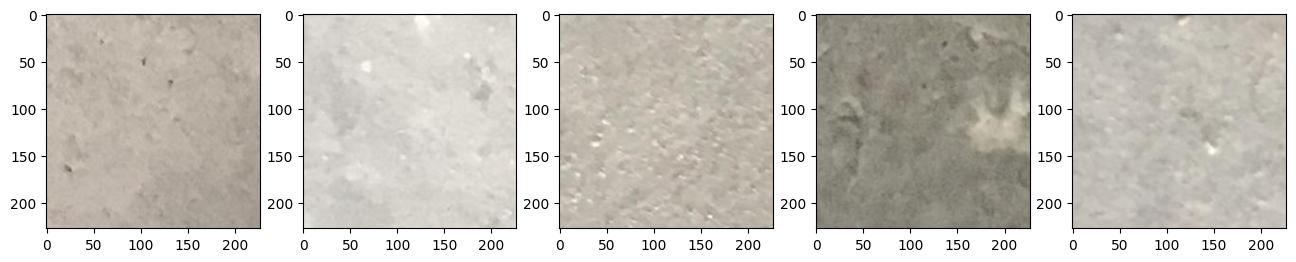

In [4]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_neg[i]) 

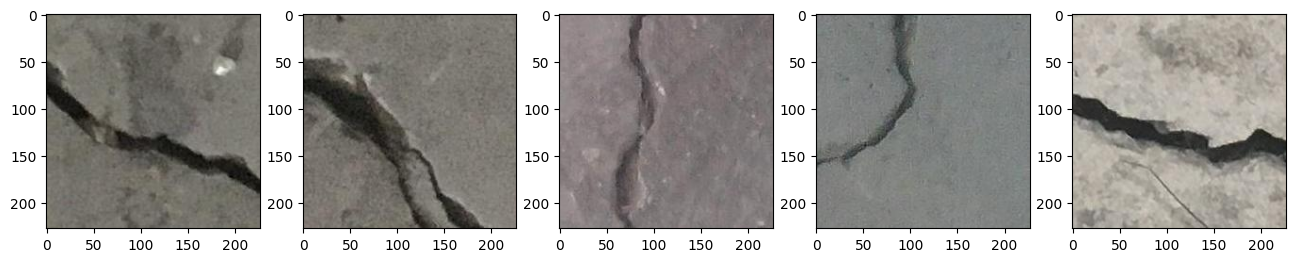

In [5]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(cracks_pos[i]) 

If we look at the image shape, we can see that the images are stored in RGB format and have a size of (227,227,3). A first step would be to get rid of the colour dimension and convert the image to greyscale. We can use the ```ImageOps``` functionality of PIL for this task.

In [6]:
image_shape = np.array(cracks_neg[0]).shape
print(image_shape)

(227, 227, 3)


In [7]:
grey_neg = []
grey_pos = []
for image in cracks_neg:
    grey_image = ImageOps.grayscale(image)
    grey_neg.append(grey_image)
    
for image in cracks_pos:
    grey_image = ImageOps.grayscale(image)
    grey_pos.append(grey_image)

In [8]:
image_shape = np.array(grey_neg[0]).shape
print(image_shape)

(227, 227)


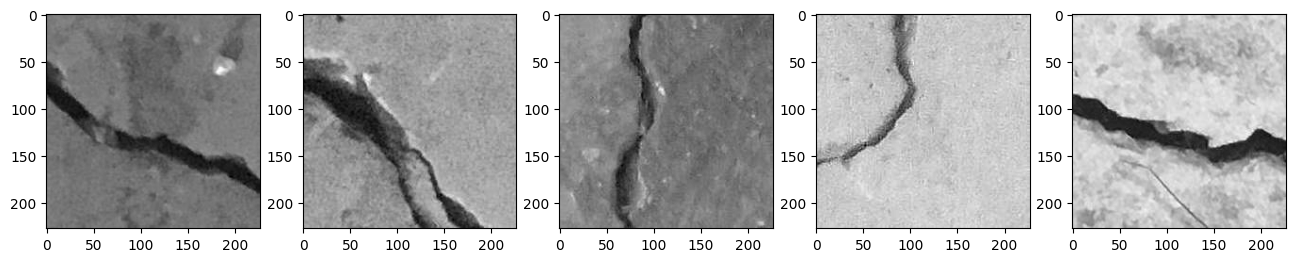

In [9]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(grey_pos[i], cmap='gray') 

In [10]:
print('values example first image:')
print('smallest pixel value:', np.min(grey_pos[0]), '; highest pixel value:', np.max(grey_pos[0]))

values example first image:
smallest pixel value: 0 ; highest pixel value: 251


Since our original images where coloured, our pixel values lie in [0, 251]. Ideally, data used for machine learning lies in [0,1]. We therefore apply **scaling** to further engineer our features:

In [11]:
def normalize(arr):
    return np.array(list(map(lambda x: x/251, arr)))

In [12]:
s_pos = []
s_neg = []
for image in grey_pos:
    scaled = normalize(np.array(image))
    s_pos.append(scaled)
for image in grey_neg:
    scaled = normalize(np.array(image))
    s_neg.append(scaled)

In [13]:
image_shape = np.array(s_neg[0]).shape
print(image_shape)

(227, 227)


In [14]:
print('smallest pixel value:', np.min(s_pos[0]), 'highest pixel value:', np.max(s_pos[0]))

smallest pixel value: 0.0 highest pixel value: 1.0


## 2. PCA
Another strategy to reduce the dimensionality is the [Principal Component Analysis](https://scikit-learn.org/stable/modules/decomposition.html#pca).

(Other dimensionality reduction algorithms: UMAP,  t-SNE)

The idea behind PCA is to project high dimensional data to a lower dimension by finding principal components which capture the directions with the highest variance while minimizing the reconstruction error.

For image data feature engineering, we can use PCA to reduce the information contained in one image to the principal features, and by doing so compressing the image. Ideally, the principal components will contain all the necessary characteristics about the represented image.

In [15]:
def compute_decomposition(n_components, data, image_size):
    min_components = min(len(data), len(data[0]))
    n_components = min(n_components, min_components)
    print(
        "Extracting the top %d features from %d images" % (n_components, len(data))
    )
    t0 = time()
    model = PCA(n_components=n_components, random_state=21).fit(data)
          
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = model.components_.reshape((n_components, image_size[0], image_size[1]))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    data_dec = model.transform(data)
    print("done in %0.3fs" % (time() - t0))
    return model, data_dec, eigenfaces

In [16]:
all_images = s_pos + s_neg

In [17]:
print(len(s_pos), len(s_neg), len(all_images))

101 101 202


In [18]:
all_flat = []
for image in all_images:
    flat_img = image.flatten()
    all_flat.append(flat_img)

In [19]:
all_flat[0].shape

(51529,)

In [20]:
pca, data_pca, eigenfaces_pca = compute_decomposition(20, all_flat, image_shape)

Extracting the top 20 features from 202 images
done in 1.086s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.085s


In [21]:
def show_images(eigenfaces):
    fig = plt.figure(figsize=(16, 10))
    n = len(eigenfaces)
    
    for i in range(n):
        ax = fig.add_subplot(int(np.floor(n/5)), 5, i + 1, xticks=[], yticks=[])
        ax.imshow(eigenfaces[i],
                  cmap=plt.cm.bone)

We have now reduced our images from (51529,) to a dimension of (20,). 

We can plot the 'eigenfaces', the principal componets of our data set, to learn how the most important features of our images look like.

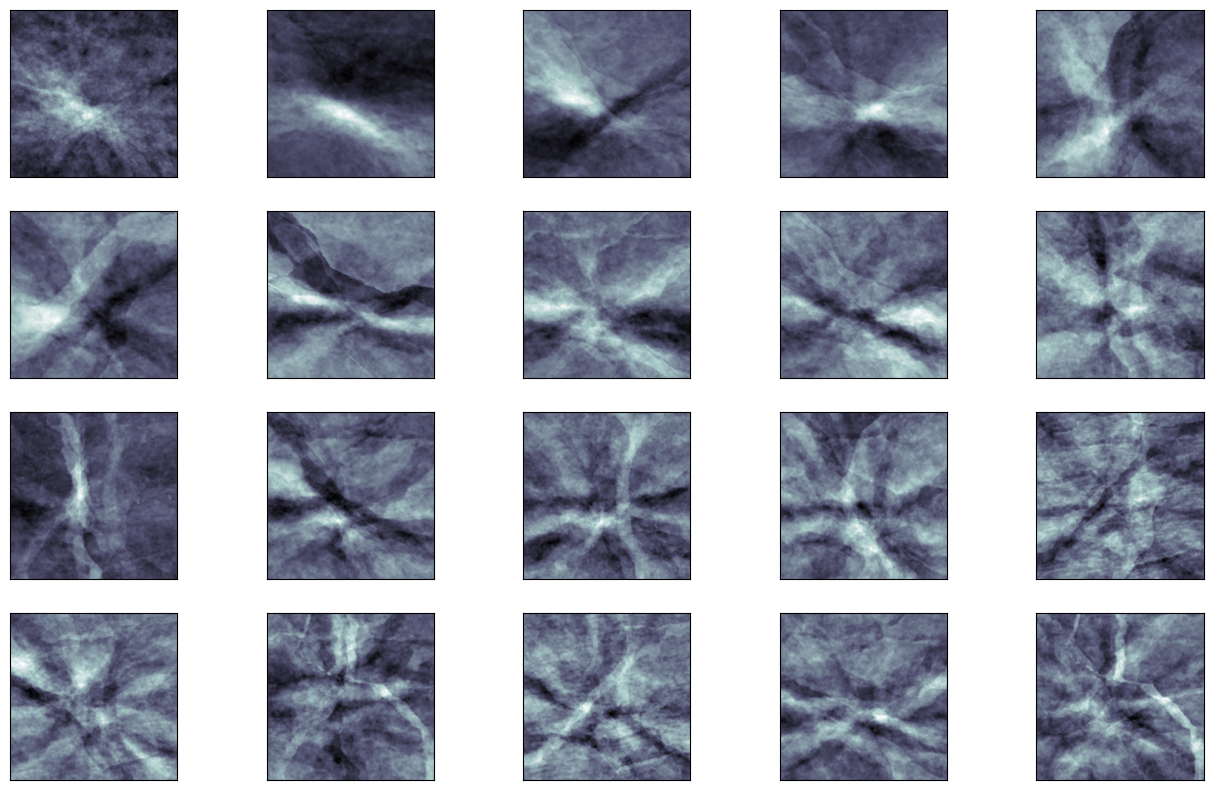

In [22]:
show_images(eigenfaces_pca)

We can also reconstruct the initial images from the principal components. This is why we can also think of PCA as a compression algorithm.

In [23]:
images_recons_pca = pca.inverse_transform(data_pca)

In [24]:
images_recons_pca.shape

(202, 51529)

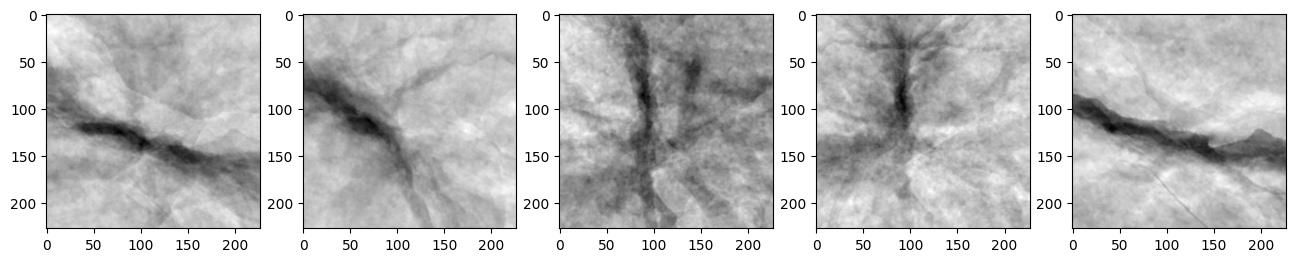

In [25]:
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(np.reshape(images_recons_pca[i], image_shape), cmap='gray') 

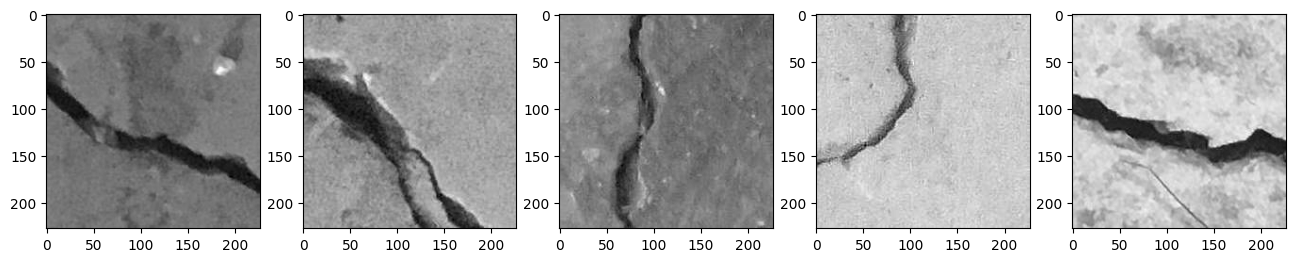

In [26]:
# as a comparison, the uncompressed images
fig, axs = plt.subplots(1,5, figsize=(16,8))
for i in range(5):
    axs[i].imshow(grey_pos[i], cmap='gray') 

PCA is not the only compression or feature reduction technique. Various other approaches can also be used for the same task, depending on the data you are using and the task you want to solve. Some examples are [Non-negative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF), [Dictionary Learning](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning), or [Factor Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis).